# Covid Prognosis Dataset

# Integrantes
Lucas Cardoso Lazari 8927439

Diogo José Costa Alves 13709881

Lucas de Angelis Oliveira 8989189

Thales Vinicius Gomes 9814265

# Descrição do dataset
Os dados a serem utilizados no projeto são provenientes de um estudo realizado em pacientes infectados por COVID-19 (doi.org/10.1080/20002297.2022.2043651). Neste estudo, o nível de proteínas em amostras de soro de pacientes internados e não internados por COVID-19 foram avaliados, portanto, o dataset consiste em uma série de features que correspondem a proteínas identificadas e um valor de intensidade da sua medida para cada paciente. A proposta do projeto é utilizar este dataset para treinar modelos para classificar os pacientes em alto risco (internados) ou baixo risco (não internados) baseado nos valores de intensidade das proteínas identificadas. São no total 132 amostras para treinamento/validação e 64 amostras para teste. Ambos os datasets (treino e teste) estão desbalanceados. O objetivo é melhorar o que foi feito no estudo publicado, visando aumentar a performance de classificação no dataset de teste.

Dado que estaremos utilizando um dataset não público e que foi utilizado por um integrante do grupo em um projeto de pesquisa anterior, este trabalho se trata de um projeto de ***tipo 2***.

---

# EDA - Exploratory Data Analysis

### 1) Importação de bibliotecas e definições básicas

In [1]:
# Importação
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import balanced_accuracy_score, make_scorer, f1_score, recall_score,precision_score
from sklearn.model_selection import RepeatedKFold, cross_val_score, GridSearchCV, cross_validate, RandomizedSearchCV

import optuna
import lightgbm as lgb

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from boruta import BorutaPy

# Ignora avisos de bibliotecas
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

In [2]:
# Parâmetros de gráficos
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

In [3]:
# Parâmetros do Pandas
pd.set_option("display.max_columns", None)

In [4]:
TRAIN_CLINICAL_FILENAME = "datasets/artigo_v2/train_set_clinical.csv"
TEST_CLINICAL_FILENAME = "datasets/artigo_v2/test_set_clinical.csv"

---

### 2) Leitura dos dados

In [5]:
train = pd.read_csv(TRAIN_CLINICAL_FILENAME, sep=";", index_col="ID")
test = pd.read_csv(TEST_CLINICAL_FILENAME, sep=";", index_col="ID")
print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
train.head()

Train shape: (132, 561)
Test shape: (64, 561)


,Age (Y),Sex,Fever,Cough,Headache,Sore throat,Muscle or Body Aches,Fadigue,Congestion or runny nose,Shortness of breath or difficulty breathing,Loss of smell,Loss of taste,Nausea or vomiting,Diarrhea,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,Freq.1265.82256301628,Freq.1270.76383114603,Freq.1277.21955007992,Freq.1282.63038110065,Freq.1293.8262919313,Freq.1299.01548864549,Freq.1305.53600567066,Freq.1310.30721649596,Freq.1315.70287569916,Freq.1320.95280783611,Freq.1324.07107187346,Freq.1327.55594407333,Freq.1331.58108934976,Freq.1339.98465957893,Freq.1348.30359762795,Freq.1357.3302556267,Freq.1362.95672607895,Freq.1368.63712906355,Freq.1372.78726661417,Freq.1377.50566247202,Freq.1383.30614758294,Freq.1389.01002905644,Freq.1394.04706384502,Freq.1399.46591504505,Freq.1404.9770099754,Freq.1409.98660647541,Freq.1421.59825430093,Freq.1427.22328919778,Freq.1431.99555134908,Freq.1438.83829046163,Freq.1443.30860845782,Freq.1447.04601543146,Freq.1453.37891443563,Freq.1455.61856178144,Freq.1459.14779913894,Freq.1464.16616494834,Freq.1470.12429734374,Freq.1477.70491383112,Freq.1485.96183531952,Freq.1497.82186371488,Freq.1508.30051240373,Freq.1514.70175609701,Freq.1517.9309481104,Freq.1522.99914751846,Freq.1527.39516015678,Freq.1533.30795661024,Freq.1538.31602411884,Freq.1544.98929953576,Freq.1549.49309231742,Freq.1554.07333161833,Freq.1560.9895266147,Freq.1566.24211112699,Freq.1571.40357692951,Freq.1577.48308092878,Freq.1584.02233200636,Freq.1591.10458447021,Freq.1595.34483768409,Freq.1604.19161332962,Freq.1608.38146933202,Freq.1611.2790141662,Freq.1619.20659524003,Freq.1625.73700133003,Freq.1633.09995837317,Freq.1636.70326472529,Freq.1640.57354450481,Freq.1649.08923599114,Freq.1655.9357306698,Freq.1663.53390642038,Freq.1671.33229659277,Freq.1677.66154555675,Freq.1687.94421312109,Freq.1694.15595567599,Freq.1699.33964318075,Freq.1704.42930680295,Freq.1709.23603195157,Freq.1715.83254187774,Freq.1721.0445200256,Freq.1726.1218533815,Freq.1730.61176155317,Freq.1740.12061901788,Freq.1745.76853759143,Freq.1747.90171482395,Freq.1756.92156671187,Freq.1765.64530443748,Freq.1769.80913741996,Freq.1773.37633931942,Freq.1780.88493187677,Freq.1785.53231760815,Freq.1794.21713030157,Freq.1799.33573844496,Freq.1809.9376813828,Freq.1819.70807089389,Freq.1822.98096756247,Freq.1830.53919878988,Freq.1835.23106901483,Freq.1840.39039983956,Freq.1850.64800128555,Freq.1870.04861014773,Freq.1874.49674198111,Freq.1880.59799181238,Freq.1891.79979750232,Freq.1898.30039812008,Freq.1903.47054385617,Freq.1909.2831633465,Freq.1913.92305980564,Freq.1920.72740465753,Freq.1934.48780363476,Freq.1944.90875784519,Freq.1952.03998687636,Freq.1958.3495860463,Freq.1963.39911937946,Freq.1972.76549068372,Freq.1979.64369462372,Freq.1987.25255033859,Freq.1995.9614532679,Freq.2004.50275606657,Freq.2014.46458166521,Freq.2021.18653447404,Freq.2027.52807710778,Freq.2032.98713905056,Freq.2044.7602330004,Freq.2052.46119506721,Freq.2058.24533424833,Freq.2062.07118114004,Freq.2070.64668714971,Freq.2074.73630640089,Freq.2079.94829884854,Freq.2090.24948361221,Freq.2100.44990262345,Freq.2113.05210215706,Freq.2122.13297897706,Freq.2128.21099676403,Freq.2136.27277429152,Freq.2143.04419457772,Freq.2147.21242083795,Freq.2153.36693907769,Freq.2158.94144479153,Freq.2164.87766710266,Freq.2171.83189597593,Freq.2177.00514262858,Freq.2182.54012190969,Freq.2187.26929655148,Freq.2194.7777838603,Freq.2202.76867207212,Freq.2211.85973125791,Freq.2216.7979248852,Freq.2224.44106274883,Freq.2230.18830781363,Freq.2241.01398322552,Freq.2245.38681433931,Freq.2251.02104963954,Freq.2257.4726297862,Freq.2266.56112591748,Freq.2273.50729921173,Freq.2280.56970760484,Freq.2290.87593912886,Freq.2301.51851513891,Freq.2305.45252886063,Freq.2309.54505260663,Freq.2313.65480260929,Freq.2325.67019406475,Freq.2334.75027257614,Freq.2340.20217597623,Freq.2352.814

- Todas as colunas com o nome iniciando em "Freq." são de medições de proteínas.

In [6]:
label_col = ['Group']
protein_cols = [col for col in train.columns if "Freq" in col]
clinical_cols = list(set(train.columns) - set(protein_cols + label_col))
symptoms_cols = [col for col in clinical_cols if col not in ["Age (Y)", "Sex"]]
features = train.drop('Group', axis=1).columns

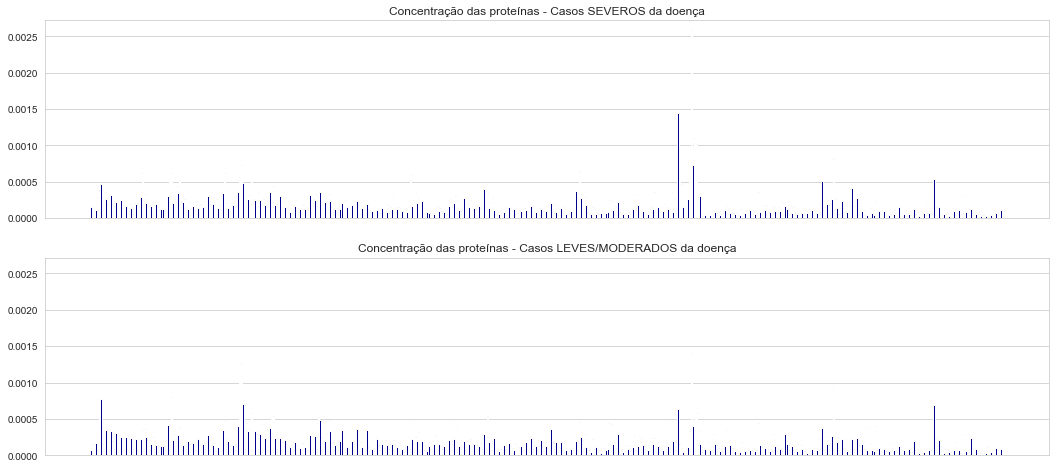

In [7]:
severe_cases = train.query("Group == 'SEVERE'")
mild_cases = train.query("Group == 'MILD'")

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=(18,8))

ax1.bar(x=protein_cols, height=severe_cases[protein_cols].mean(), color='darkblue')
ax1.set_title('Concentração das proteínas - Casos SEVEROS da doença')
plt.xticks([])
plt.grid()

ax2.bar(x=protein_cols, height=mild_cases[protein_cols].mean(), color='darkblue')
ax2.set_title('Concentração das proteínas - Casos LEVES/MODERADOS da doença')
plt.xticks([])
plt.grid()

plt.show()

Nesta visualização estão sendo comparados os valores médios de concentração das proteínas para cada uma das labels. Pode-se observar que existem algumas diferenças notáveis entre os valores dos dois gráficos e é esperado que essa informação auxilie o modelo em suas predições.

---

### 3) Explorando os dados

In [8]:
train.describe()

,Age (Y),Fever,Cough,Headache,Sore throat,Muscle or Body Aches,Fadigue,Congestion or runny nose,Shortness of breath or difficulty breathing,Loss of smell,Loss of taste,Nausea or vomiting,Diarrhea,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,Freq.1265.82256301628,Freq.1270.76383114603,Freq.1277.21955007992,Freq.1282.63038110065,Freq.1293.8262919313,Freq.1299.01548864549,Freq.1305.53600567066,Freq.1310.30721649596,Freq.1315.70287569916,Freq.1320.95280783611,Freq.1324.07107187346,Freq.1327.55594407333,Freq.1331.58108934976,Freq.1339.98465957893,Freq.1348.30359762795,Freq.1357.3302556267,Freq.1362.95672607895,Freq.1368.63712906355,Freq.1372.78726661417,Freq.1377.50566247202,Freq.1383.30614758294,Freq.1389.01002905644,Freq.1394.04706384502,Freq.1399.46591504505,Freq.1404.9770099754,Freq.1409.98660647541,Freq.1421.59825430093,Freq.1427.22328919778,Freq.1431.99555134908,Freq.1438.83829046163,Freq.1443.30860845782,Freq.1447.04601543146,Freq.1453.37891443563,Freq.1455.61856178144,Freq.1459.14779913894,Freq.1464.16616494834,Freq.1470.12429734374,Freq.1477.70491383112,Freq.1485.96183531952,Freq.1497.82186371488,Freq.1508.30051240373,Freq.1514.70175609701,Freq.1517.9309481104,Freq.1522.99914751846,Freq.1527.39516015678,Freq.1533.30795661024,Freq.1538.31602411884,Freq.1544.98929953576,Freq.1549.49309231742,Freq.1554.07333161833,Freq.1560.9895266147,Freq.1566.24211112699,Freq.1571.40357692951,Freq.1577.48308092878,Freq.1584.02233200636,Freq.1591.10458447021,Freq.1595.34483768409,Freq.1604.19161332962,Freq.1608.38146933202,Freq.1611.2790141662,Freq.1619.20659524003,Freq.1625.73700133003,Freq.1633.09995837317,Freq.1636.70326472529,Freq.1640.57354450481,Freq.1649.08923599114,Freq.1655.9357306698,Freq.1663.53390642038,Freq.1671.33229659277,Freq.1677.66154555675,Freq.1687.94421312109,Freq.1694.15595567599,Freq.1699.33964318075,Freq.1704.42930680295,Freq.1709.23603195157,Freq.1715.83254187774,Freq.1721.0445200256,Freq.1726.1218533815,Freq.1730.61176155317,Freq.1740.12061901788,Freq.1745.76853759143,Freq.1747.90171482395,Freq.1756.92156671187,Freq.1765.64530443748,Freq.1769.80913741996,Freq.1773.37633931942,Freq.1780.88493187677,Freq.1785.53231760815,Freq.1794.21713030157,Freq.1799.33573844496,Freq.1809.9376813828,Freq.1819.70807089389,Freq.1822.98096756247,Freq.1830.53919878988,Freq.1835.23106901483,Freq.1840.39039983956,Freq.1850.64800128555,Freq.1870.04861014773,Freq.1874.49674198111,Freq.1880.59799181238,Freq.1891.79979750232,Freq.1898.30039812008,Freq.1903.47054385617,Freq.1909.2831633465,Freq.1913.92305980564,Freq.1920.72740465753,Freq.1934.48780363476,Freq.1944.90875784519,Freq.1952.03998687636,Freq.1958.3495860463,Freq.1963.39911937946,Freq.1972.76549068372,Freq.1979.64369462372,Freq.1987.25255033859,Freq.1995.9614532679,Freq.2004.50275606657,Freq.2014.46458166521,Freq.2021.18653447404,Freq.2027.52807710778,Freq.2032.98713905056,Freq.2044.7602330004,Freq.2052.46119506721,Freq.2058.24533424833,Freq.2062.07118114004,Freq.2070.64668714971,Freq.2074.73630640089,Freq.2079.94829884854,Freq.2090.24948361221,Freq.2100.44990262345,Freq.2113.05210215706,Freq.2122.13297897706,Freq.2128.21099676403,Freq.2136.27277429152,Freq.2143.04419457772,Freq.2147.21242083795,Freq.2153.36693907769,Freq.2158.94144479153,Freq.2164.87766710266,Freq.2171.83189597593,Freq.2177.00514262858,Freq.2182.54012190969,Freq.2187.26929655148,Freq.2194.7777838603,Freq.2202.76867207212,Freq.2211.85973125791,Freq.2216.7979248852,Freq.2224.44106274883,Freq.2230.18830781363,Freq.2241.01398322552,Freq.2245.38681433931,Freq.2251.02104963954,Freq.2257.4726297862,Freq.2266.56112591748,Freq.2273.50729921173,Freq.2280.56970760484,Freq.2290.87593912886,Freq.2301.51851513891,Freq.2305.45252886063,Freq.2309.54505260663,Freq.2313.65480260929,Freq.2325.67019406475,Freq.2334.75027257614,Freq.2340.20217597623,Freq.2352.8145161

#### 3.1) Análise dos dados faltantes

In [9]:
print(f'Total de dados faltantes do dataset: {train.isna().sum().sum()}')
print(f'Quantidade de dados no dataset: {train.size}')
print(f'Representatividade dos faltantes: {round(train.isna().sum().sum() / train.size * 100, 4)}%')

Total de dados faltantes do dataset: 12
Quantidade de dados no dataset: 74052
Representatividade dos faltantes: 0.0162%


In [10]:
# Check missing values - TRAIN
train.isna().sum().to_frame().sort_values(0, ascending=False).head()

,0
Loss of smell,1
Fever,1
Cough,1
Headache,1
Sore throat,1


In [11]:
train[train.isna().any(1)]

,Age (Y),Sex,Fever,Cough,Headache,Sore throat,Muscle or Body Aches,Fadigue,Congestion or runny nose,Shortness of breath or difficulty breathing,Loss of smell,Loss of taste,Nausea or vomiting,Diarrhea,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,Freq.1265.82256301628,Freq.1270.76383114603,Freq.1277.21955007992,Freq.1282.63038110065,Freq.1293.8262919313,Freq.1299.01548864549,Freq.1305.53600567066,Freq.1310.30721649596,Freq.1315.70287569916,Freq.1320.95280783611,Freq.1324.07107187346,Freq.1327.55594407333,Freq.1331.58108934976,Freq.1339.98465957893,Freq.1348.30359762795,Freq.1357.3302556267,Freq.1362.95672607895,Freq.1368.63712906355,Freq.1372.78726661417,Freq.1377.50566247202,Freq.1383.30614758294,Freq.1389.01002905644,Freq.1394.04706384502,Freq.1399.46591504505,Freq.1404.9770099754,Freq.1409.98660647541,Freq.1421.59825430093,Freq.1427.22328919778,Freq.1431.99555134908,Freq.1438.83829046163,Freq.1443.30860845782,Freq.1447.04601543146,Freq.1453.37891443563,Freq.1455.61856178144,Freq.1459.14779913894,Freq.1464.16616494834,Freq.1470.12429734374,Freq.1477.70491383112,Freq.1485.96183531952,Freq.1497.82186371488,Freq.1508.30051240373,Freq.1514.70175609701,Freq.1517.9309481104,Freq.1522.99914751846,Freq.1527.39516015678,Freq.1533.30795661024,Freq.1538.31602411884,Freq.1544.98929953576,Freq.1549.49309231742,Freq.1554.07333161833,Freq.1560.9895266147,Freq.1566.24211112699,Freq.1571.40357692951,Freq.1577.48308092878,Freq.1584.02233200636,Freq.1591.10458447021,Freq.1595.34483768409,Freq.1604.19161332962,Freq.1608.38146933202,Freq.1611.2790141662,Freq.1619.20659524003,Freq.1625.73700133003,Freq.1633.09995837317,Freq.1636.70326472529,Freq.1640.57354450481,Freq.1649.08923599114,Freq.1655.9357306698,Freq.1663.53390642038,Freq.1671.33229659277,Freq.1677.66154555675,Freq.1687.94421312109,Freq.1694.15595567599,Freq.1699.33964318075,Freq.1704.42930680295,Freq.1709.23603195157,Freq.1715.83254187774,Freq.1721.0445200256,Freq.1726.1218533815,Freq.1730.61176155317,Freq.1740.12061901788,Freq.1745.76853759143,Freq.1747.90171482395,Freq.1756.92156671187,Freq.1765.64530443748,Freq.1769.80913741996,Freq.1773.37633931942,Freq.1780.88493187677,Freq.1785.53231760815,Freq.1794.21713030157,Freq.1799.33573844496,Freq.1809.9376813828,Freq.1819.70807089389,Freq.1822.98096756247,Freq.1830.53919878988,Freq.1835.23106901483,Freq.1840.39039983956,Freq.1850.64800128555,Freq.1870.04861014773,Freq.1874.49674198111,Freq.1880.59799181238,Freq.1891.79979750232,Freq.1898.30039812008,Freq.1903.47054385617,Freq.1909.2831633465,Freq.1913.92305980564,Freq.1920.72740465753,Freq.1934.48780363476,Freq.1944.90875784519,Freq.1952.03998687636,Freq.1958.3495860463,Freq.1963.39911937946,Freq.1972.76549068372,Freq.1979.64369462372,Freq.1987.25255033859,Freq.1995.9614532679,Freq.2004.50275606657,Freq.2014.46458166521,Freq.2021.18653447404,Freq.2027.52807710778,Freq.2032.98713905056,Freq.2044.7602330004,Freq.2052.46119506721,Freq.2058.24533424833,Freq.2062.07118114004,Freq.2070.64668714971,Freq.2074.73630640089,Freq.2079.94829884854,Freq.2090.24948361221,Freq.2100.44990262345,Freq.2113.05210215706,Freq.2122.13297897706,Freq.2128.21099676403,Freq.2136.27277429152,Freq.2143.04419457772,Freq.2147.21242083795,Freq.2153.36693907769,Freq.2158.94144479153,Freq.2164.87766710266,Freq.2171.83189597593,Freq.2177.00514262858,Freq.2182.54012190969,Freq.2187.26929655148,Freq.2194.7777838603,Freq.2202.76867207212,Freq.2211.85973125791,Freq.2216.7979248852,Freq.2224.44106274883,Freq.2230.18830781363,Freq.2241.01398322552,Freq.2245.38681433931,Freq.2251.02104963954,Freq.2257.4726297862,Freq.2266.56112591748,Freq.2273.50729921173,Freq.2280.56970760484,Freq.2290.87593912886,Freq.2301.51851513891,Freq.2305.45252886063,Freq.2309.54505260663,Freq.2313.65480260929,Freq.2325.67019406475,Freq.2334.75027257614,Freq.2340.20217597623,Freq.2352.814

- Temos apenas um caso com dados faltantes no dataset de treino, sendo que estes são apenas de dados sintomáticos, não de proteínas.

#### 3.2) Distribuição da variável alvo

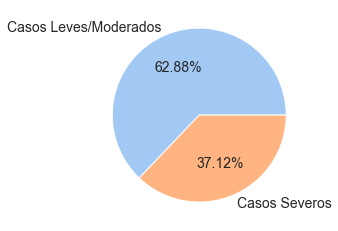

In [12]:
plt.pie(
    train['Group'].value_counts(normalize=True),
    labels=['Casos Leves/Moderados', 'Casos Severos'],
    colors= sns.color_palette('pastel')[:2],
    autopct='%.2f%%',
    textprops={'fontsize': 14}
    )
plt.show()

- Não há uma distribuição igualitária da variável de interesse no dataset, porém a diferença não é grande o suficiente para justificar medidas de balanceamento (oversampling, undersampling, etc)

#### 3.3) Checagem de valores iguais a 0

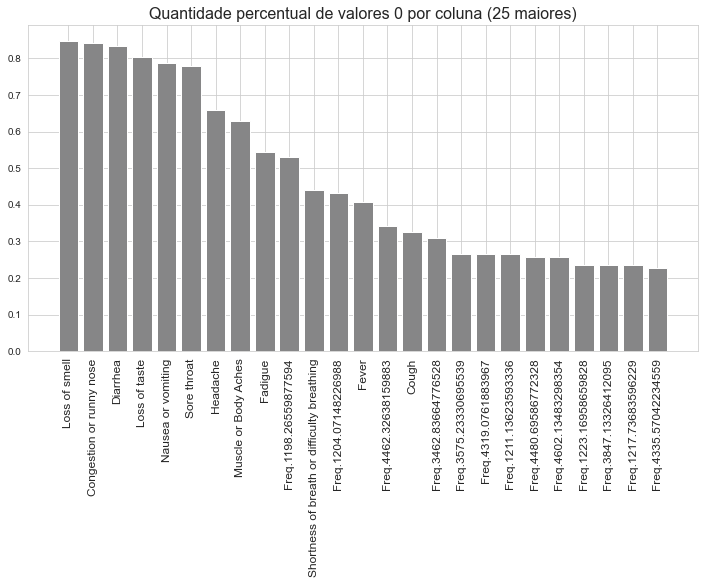

In [13]:
train_zeros = np.sum(train==0).to_frame().sort_values(0, ascending=False).rename({0:"qt_0"}, axis=1)
train_zeros["%_qt_0"] = train_zeros["qt_0"]/train.shape[0]

plt.figure(figsize=(12,6))
plt.bar(train_zeros.index[:25], train_zeros["%_qt_0"][:25], color='#868687')
plt.title('Quantidade percentual de valores 0 por coluna (25 maiores)', fontdict={'fontsize':16})
plt.xticks(rotation = 90, fontsize=12)
plt.show()

- Existem features com grande quantidades de zeros (algumas mais da metade)
- A maior parte dos valores 0 estão concentrados nas colunas de dados clínicos, o que faz sentido tendo em vista que são dados binários e que há menos casos de doença severa no dataset

#### 3.4) Distribuição das variáveis sintomáticas e clínicas em relação aos casos da doença

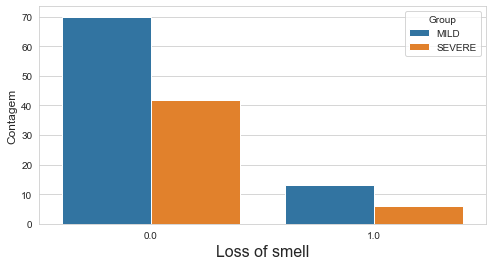

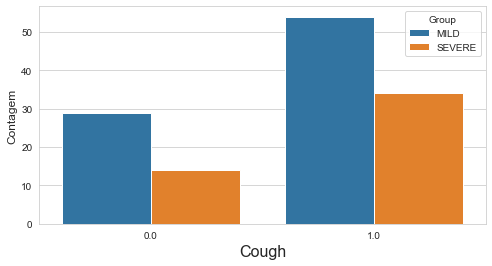

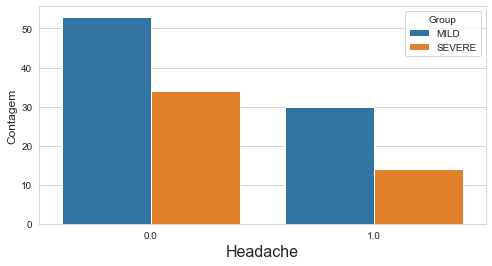

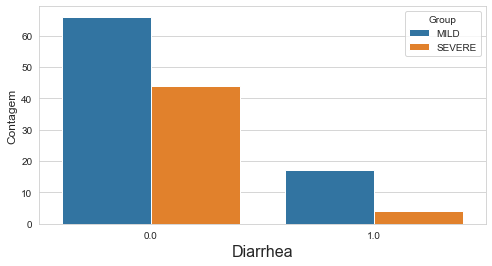

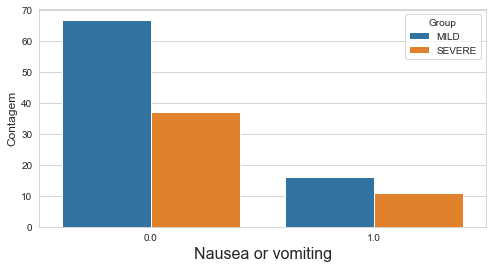

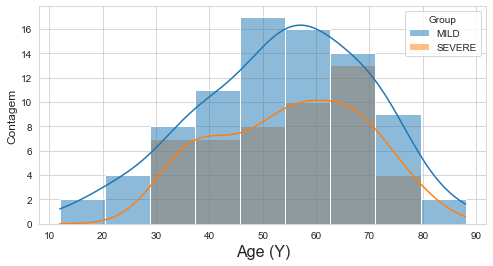

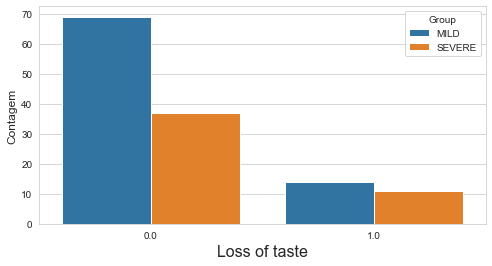

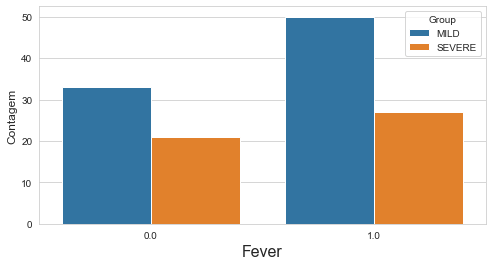

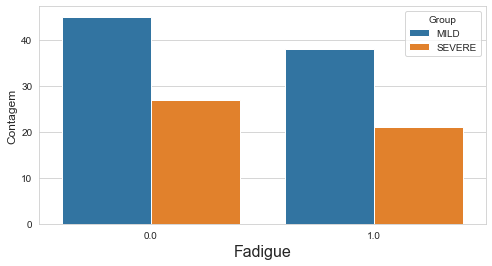

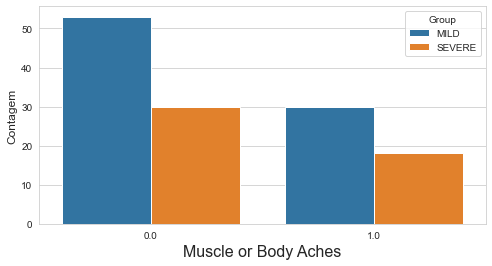

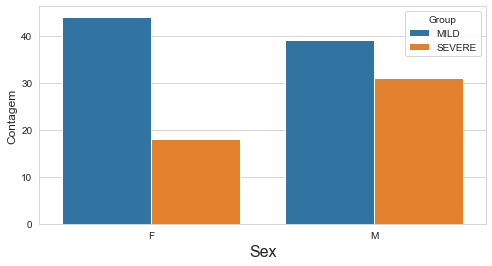

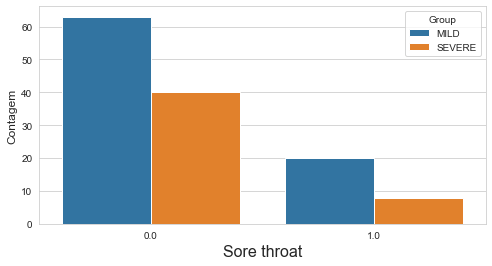

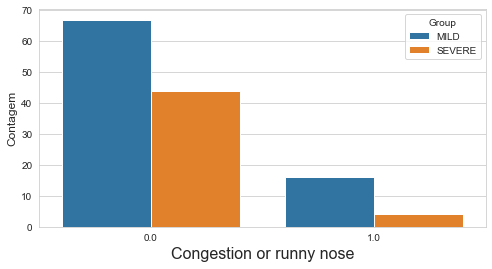

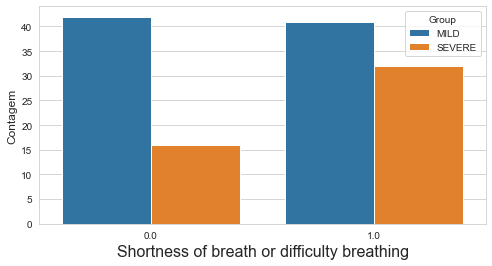

In [14]:
# Clinical Features Distribution
for col in clinical_cols:
    fig, ax = plt.subplots(ncols=1, figsize=(8, 4))
    if col not in ['Age (Y)']:
        _ = sns.countplot(data=train, x=col, hue='Group')
    else:
        _ =sns.histplot(data=train, x=col, hue='Group', kde=True)
        
    plt.xlabel(xlabel=col, fontdict={'fontsize':16})
    plt.ylabel(ylabel="Contagem", fontdict={'fontsize':12})

#### Concentração dos sintomas por caso da doença

In [15]:
df_symptoms = pd.merge(train[symptoms_cols], train['Group'], on='ID')
df_symptoms.groupby(['Group']).mean()

,Loss of smell,Cough,Headache,Diarrhea,Nausea or vomiting,Loss of taste,Fever,Fadigue,Muscle or Body Aches,Sore throat,Congestion or runny nose,Shortness of breath or difficulty breathing
Group,,,,,,,,,,,,
MILD,0.156627,0.650602,0.361446,0.204819,0.192771,0.168675,0.60241,0.457831,0.361446,0.240964,0.192771,0.493976
SEVERE,0.125000,0.708333,0.291667,0.083333,0.229167,0.229167,0.56250,0.437500,0.375000,0.166667,0.083333,0.666667


- Interpretação: como os dados são binários, a média indica a % de vezes que o sintoma apareceu. <br>
Por exemplo: Fever x Severe = 0.56 significa que 56% dos casos severos apresentaram febre como sintoma

#### 3.4.2) Analisando os casos da doença por sexo e faixas etárias

In [16]:
# Criando a faixa de grupos etários
train["age_group"] = ""
train.loc[train["Age (Y)"] <= 13, "age_group"] = "0 - 13"
train.loc[(train["Age (Y)"] > 13) & (train["Age (Y)"] <= 21), "age_group"] = "13 - 21"
train.loc[(train["Age (Y)"] > 21) & (train["Age (Y)"] <= 50), "age_group"] = "21 - 50"
train.loc[(train["Age (Y)"] > 50) & (train["Age (Y)"] <= 70), "age_group"] = "50 - 70"
train.loc[(train["Age (Y)"] > 70) & (train["Age (Y)"] <= 100), "age_group"] = "70 - 100"

# Analisando os resultados
pd.crosstab(index=[train['age_group'], train['Sex']], columns=train['Group'])

Group          MILD  SEVERE
age_group Sex              
0 - 13    F       1       0
13 - 21   F       1       0
          M       1       0
21 - 50   F      13       4
          M      15      13
50 - 70   F      23      14
          M      17      13
70 - 100  F       6       0
          M       6       5

- Não existem casos severos para idades até 21 anos

#### 3.5) Analisando a diferença da média dos valores das proteínas por caso de doença

##### Antes de tudo, precisamos escalar as concentrações de proteínas para podermos ter um efeito comparativo entre as mesmas. Uma diferença média de 0,01 entre um caso leve e moderado da proteína A pode não ter o mesmo peso que a mesma diferença para a proteína B

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaled_protein_df = pd.DataFrame(index=train.index,
                          data=MinMaxScaler().fit_transform(train[protein_cols]),
                          columns=[i for i in train[protein_cols]])
scaled_protein_df

,Freq.1198.26559877594,Freq.1204.07148226988,Freq.1211.13623593336,Freq.1217.73683596229,Freq.1223.16958659828,Freq.1234.45996741201,Freq.1239.41043347512,Freq.1244.8230732813,Freq.1254.64710066874,Freq.1261.3335177338,Freq.1265.82256301628,Freq.1270.76383114603,Freq.1277.21955007992,Freq.1282.63038110065,Freq.1293.8262919313,Freq.1299.01548864549,Freq.1305.53600567066,Freq.1310.30721649596,Freq.1315.70287569916,Freq.1320.95280783611,Freq.1324.07107187346,Freq.1327.55594407333,Freq.1331.58108934976,Freq.1339.98465957893,Freq.1348.30359762795,Freq.1357.3302556267,Freq.1362.95672607895,Freq.1368.63712906355,Freq.1372.78726661417,Freq.1377.50566247202,Freq.1383.30614758294,Freq.1389.01002905644,Freq.1394.04706384502,Freq.1399.46591504505,Freq.1404.9770099754,Freq.1409.98660647541,Freq.1421.59825430093,Freq.1427.22328919778,Freq.1431.99555134908,Freq.1438.83829046163,Freq.1443.30860845782,Freq.1447.04601543146,Freq.1453.37891443563,Freq.1455.61856178144,Freq.1459.14779913894,Freq.1464.16616494834,Freq.1470.12429734374,Freq.1477.70491383112,Freq.1485.96183531952,Freq.1497.82186371488,Freq.1508.30051240373,Freq.1514.70175609701,Freq.1517.9309481104,Freq.1522.99914751846,Freq.1527.39516015678,Freq.1533.30795661024,Freq.1538.31602411884,Freq.1544.98929953576,Freq.1549.49309231742,Freq.1554.07333161833,Freq.1560.9895266147,Freq.1566.24211112699,Freq.1571.40357692951,Freq.1577.48308092878,Freq.1584.02233200636,Freq.1591.10458447021,Freq.1595.34483768409,Freq.1604.19161332962,Freq.1608.38146933202,Freq.1611.2790141662,Freq.1619.20659524003,Freq.1625.73700133003,Freq.1633.09995837317,Freq.1636.70326472529,Freq.1640.57354450481,Freq.1649.08923599114,Freq.1655.9357306698,Freq.1663.53390642038,Freq.1671.33229659277,Freq.1677.66154555675,Freq.1687.94421312109,Freq.1694.15595567599,Freq.1699.33964318075,Freq.1704.42930680295,Freq.1709.23603195157,Freq.1715.83254187774,Freq.1721.0445200256,Freq.1726.1218533815,Freq.1730.61176155317,Freq.1740.12061901788,Freq.1745.76853759143,Freq.1747.90171482395,Freq.1756.92156671187,Freq.1765.64530443748,Freq.1769.80913741996,Freq.1773.37633931942,Freq.1780.88493187677,Freq.1785.53231760815,Freq.1794.21713030157,Freq.1799.33573844496,Freq.1809.9376813828,Freq.1819.70807089389,Freq.1822.98096756247,Freq.1830.53919878988,Freq.1835.23106901483,Freq.1840.39039983956,Freq.1850.64800128555,Freq.1870.04861014773,Freq.1874.49674198111,Freq.1880.59799181238,Freq.1891.79979750232,Freq.1898.30039812008,Freq.1903.47054385617,Freq.1909.2831633465,Freq.1913.92305980564,Freq.1920.72740465753,Freq.1934.48780363476,Freq.1944.90875784519,Freq.1952.03998687636,Freq.1958.3495860463,Freq.1963.39911937946,Freq.1972.76549068372,Freq.1979.64369462372,Freq.1987.25255033859,Freq.1995.9614532679,Freq.2004.50275606657,Freq.2014.46458166521,Freq.2021.18653447404,Freq.2027.52807710778,Freq.2032.98713905056,Freq.2044.7602330004,Freq.2052.46119506721,Freq.2058.24533424833,Freq.2062.07118114004,Freq.2070.64668714971,Freq.2074.73630640089,Freq.2079.94829884854,Freq.2090.24948361221,Freq.2100.44990262345,Freq.2113.05210215706,Freq.2122.13297897706,Freq.2128.21099676403,Freq.2136.27277429152,Freq.2143.04419457772,Freq.2147.21242083795,Freq.2153.36693907769,Freq.2158.94144479153,Freq.2164.87766710266,Freq.2171.83189597593,Freq.2177.00514262858,Freq.2182.54012190969,Freq.2187.26929655148,Freq.2194.7777838603,Freq.2202.76867207212,Freq.2211.85973125791,Freq.2216.7979248852,Freq.2224.44106274883,Freq.2230.18830781363,Freq.2241.01398322552,Freq.2245.38681433931,Freq.2251.02104963954,Freq.2257.4726297862,Freq.2266.56112591748,Freq.2273.50729921173,Freq.2280.56970760484,Freq.2290.87593912886,Freq.2301.51851513891,Freq.2305.45252886063,Freq.2309.54505260663,Freq.2313.65480260929,Freq.2325.67019406475,Freq.2334.75027257614,Freq.2340.20217597623,Freq.2352.81451617918,Freq.2368.4169597269,Freq.2376.18798980932,Freq.2382.42710415359,Freq.2395.92741519698,Freq.2408.3387899142,Freq.2420.14441330189,Freq.2433.47999073313,Freq.2439.77083354138,Freq.2449.869009

In [18]:
protein_df = pd.merge(scaled_protein_df, train['Group'], on='ID')
group_diff = (protein_df.groupby('Group').get_group('MILD').mean() - protein_df.groupby('Group').get_group('SEVERE').mean())
group_diff.abs().sort_values(ascending=False).head(20)

Freq.4266.97846896688    0.132791
Freq.4395.11277752994    0.130435
Freq.4374.2137825978     0.116444
Freq.6239.85288969931    0.109431
Freq.8943.8000787644     0.106915
Freq.3150.86394132739    0.106624
Freq.4008.05278467097    0.106217
Freq.3983.61553339652    0.104993
Freq.4356.67963477143    0.102551
Freq.4283.95182164633    0.101443
Freq.8564.37429417127    0.101418
Freq.2032.98713905056    0.098545
Freq.1514.70175609701    0.093842
Freq.4244.79783425292    0.092859
Freq.5720.79450801948    0.091743
Freq.3841.62499763838    0.091583
Freq.2251.02104963954    0.091432
Freq.4551.18066730266    0.091144
Freq.4659.55667096198    0.090305
Freq.4530.88583193204    0.088467
dtype: float64

- Podemos perceber que existem diferenças consideráveis na concentração das proteínas a depender da severidade da doença

#### Distribuição de 20 proteínas aleatórias em relação ao caso da doença

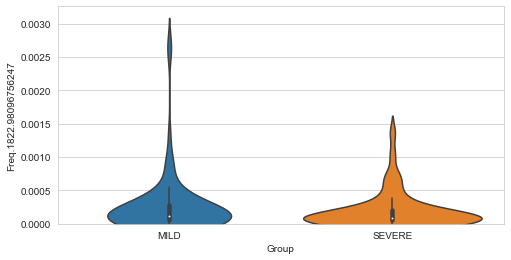

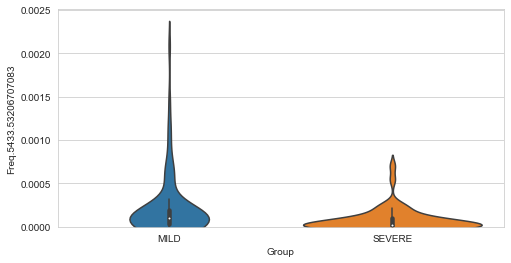

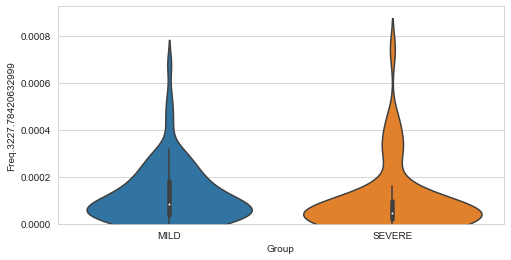

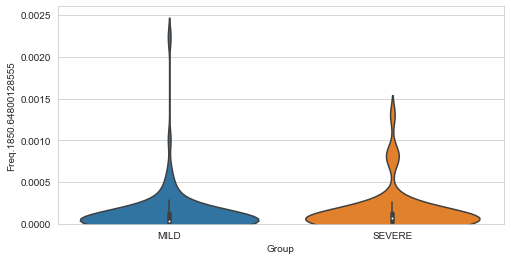

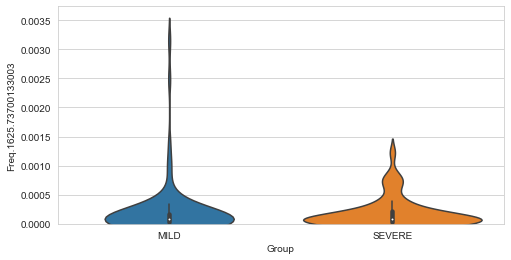

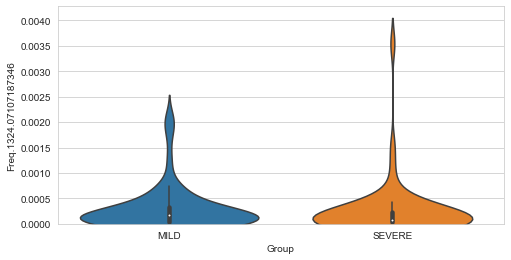

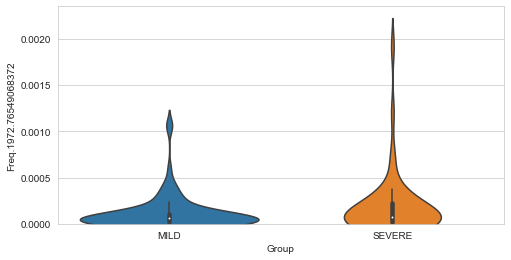

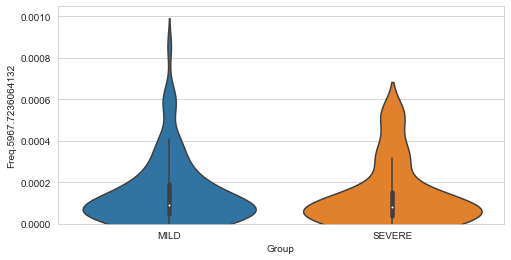

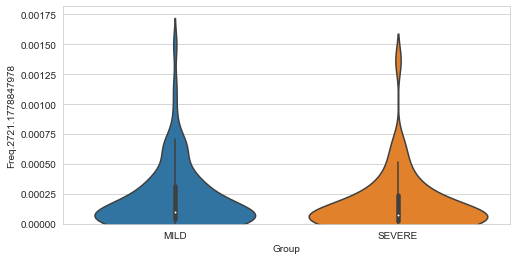

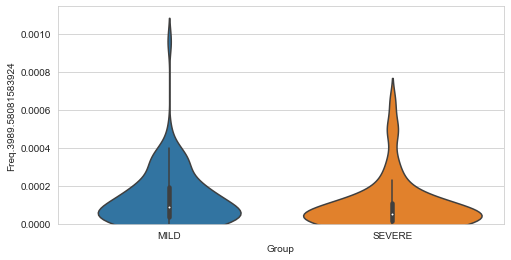

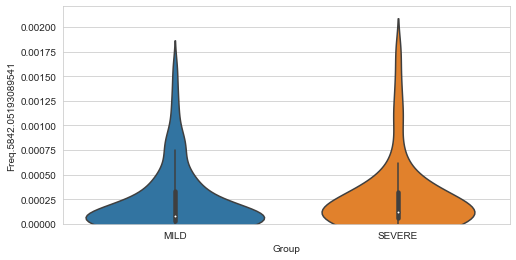

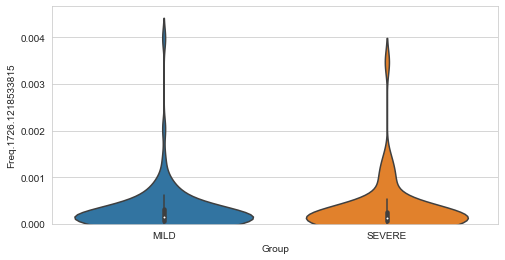

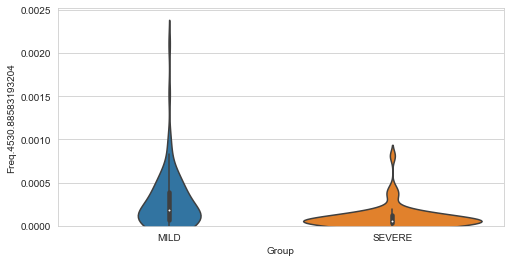

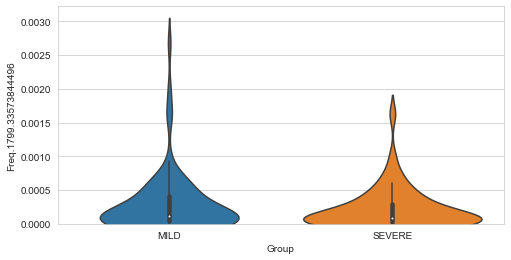

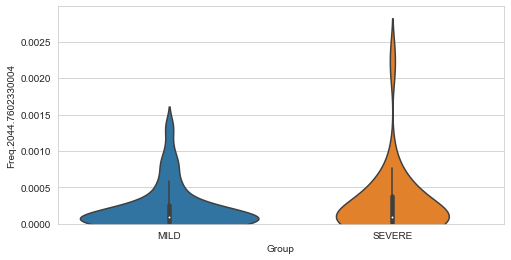

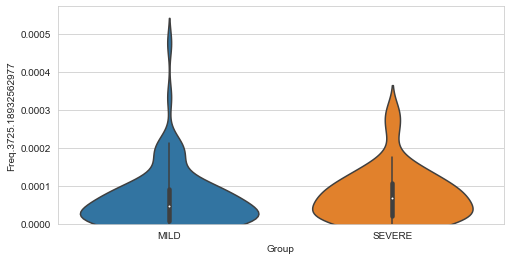

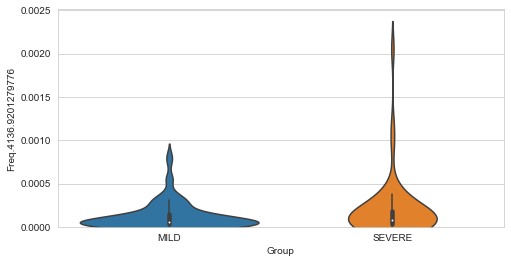

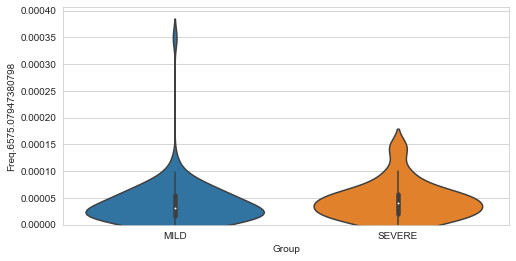

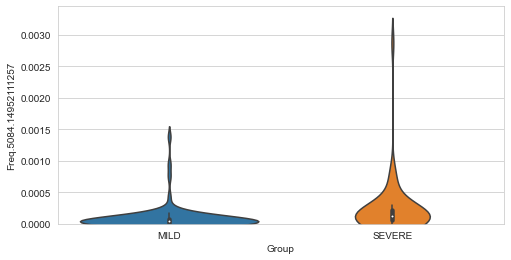

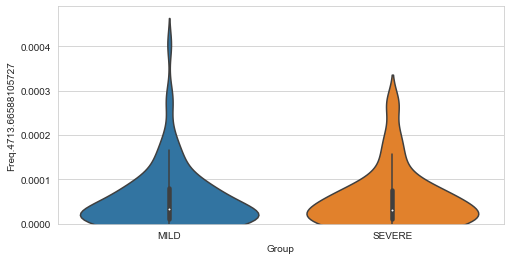

In [19]:
np.random.seed(42)
for coluna in np.random.randint(low=0, high=len(protein_cols), size=20):
    fig, ax = plt.subplots(ncols=1, figsize=(8, 4))
    sns.violinplot(data=train, y=protein_cols[coluna], x='Group')
    minimo = min(train[protein_cols[coluna]])
    plt.ylim(minimo)

- Apesar da análise das proteínas ter sido aleatória, podemos perceber que a concentração de várias delas variam conforme o caso da doença, o que é um bom indicativo de que o modelo pode aprender a diferenciar a gravidade da doença com base na concentração proteica.

#### 3.6) Analisando as correlações lineares

In [20]:
correlacoes = (
    pd.DataFrame(train.corr()[train.corr() < 1] # tiramos o 1 para ignorar a correlação com si mesma
                 .abs()
                 .unstack()
                 .sort_values()
                 .dropna()
                 )
    .reset_index()
    .rename(columns={'level_0':'Variável 1', 'level_1':'Variável 2', 0:'Correlação Absoluta'})
)
correlacoes.tail(20).sort_values(by='Correlação Absoluta', ascending=False)

,Variável 1,Variável 2,Correlação Absoluta
311921,Freq.6972.60830431122,Freq.6985.68325773006,0.933667
311920,Freq.6985.68325773006,Freq.6972.60830431122,0.933667
311919,Freq.4047.41402650454,Freq.4084.57708789945,0.909658
311918,Freq.4084.57708789945,Freq.4047.41402650454,0.909658
311917,Freq.6025.47596309106,Freq.6046.04318028897,0.897315
311916,Freq.6046.04318028897,Freq.6025.47596309106,0.897315
311915,Freq.9594.78353572215,Freq.5944.60159738155,0.885217
311914,Freq.5944.60159738155,Freq.9594.78353572215,0.885217
311913,Freq.6025.47596309106,Freq.6006.61013290292,0.881839
311912,Freq.6006.61013290292,Freq.6025.47596309106,0.881839


In [21]:
(correlacoes['Correlação Absoluta'] > 0.8).sum()

58

- Percebemos que há varias proteinas com uma correlação linear razoávelmente alta
- Isso não será um grande problema, pois utilizaremos de técnicas de feature selection que tenderão a mitigar o problema das altas correlações

Em relação à implementação da Análise Exploratória:

- Para a manipulação dos dados e cálculos gerais foram utilizadas as bibliotecas amplamente conhecidas e aplicadas em projetos de ML **pandas** e **numpy**, que foram escolhidas muito devido a sua eficácia e por ser de conhecimento comum entre os integrantes do grupo


- Para a visualização de dados estão sendo utilizadas as bibliotecas **matplotlib** - para plots que necessitam de mais flexibilidade e possibilidade de alterar parâmetros - e **seaborn** - pois costuma gerar uma visualização mais agradável visualmente

# Modelagem

# Observações Importantes:
O Grupo testou várias configurações de pré-processamentos, feature engine, otimização de hiperparâmetros e algoritmos para a modelagem. <br>
Nem todos os testes efetuados estão no presente notebook, por isso, deixamos o link utilizado no GitHub para que, caso seja de interesse, verifique todos os passos e procedimentos que adotamos ao longo do projeto.

https://github.com/LCLazari/MAC5832_prognostico_covid/tree/LCLazari-only-normalized

#### Nosso desafio é prever com boa precisão os casos em que a doença do Covid irá se manifestar de maneira agressiva, para que se possa dar o tratamento adequeado para o paciente.
#### Porém, não podemos esquecer que falsos positivos podem vir a ter altos custos financeiros (por exemplo: superestimar a quantidade de UTI necessárias). Tendo esses fatos em mente, o grupo optou por otimizar a métrica da <span style="color:red">acurácia balanceada</span>, pois dessa forma conseguimos contornar o problema do leve desbalanceamento da base e alcançar o objetivo de prever o caso da doença sem negligenciar os falsos positivos

In [22]:
SEED = 42

In [23]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [24]:
train['Group'] = np.where(train['Group'] == 'MILD', 0, 1)
test['Group'] = np.where(test['Group'] == 'MILD', 0, 1)
train['Sex'] = np.where(train['Sex'] == 'F', 1, 0)
test['Sex'] = np.where(test['Sex'] == 'F', 1, 0)

In [25]:
X_train = train[features]
y_train = train[label_col]
X_test = test[features]
y_test = test[label_col]

In [26]:
# Define o método de cross validation
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=SEED)

## Realizando um teste rápido de algoritmos

In [27]:
metrics = ['balanced_accuracy', 'accuracy', 'f1', 'roc_auc', 'precision', 'recall']

algorithms = ['LogisticRegression', 'GaussianNB', 'RandomForestClassifier',
              'SVC', 'KNeighborsClassifier', 'LGBMClassifier']

In [28]:
results_df = pd.DataFrame()

for algo in algorithms:
    
    scaler = StandardScaler()
    # Precisamos escalar os dados para que não-arvores não sejam penalizados
    pipe = Pipeline(steps=[('scaler', scaler),
                          ('model', eval(algo)())])
    
    cv_results = cross_validate(estimator=pipe, X=X_train, y=y_train, cv=rkf, n_jobs=-1,
                                scoring=metrics, return_train_score=True)
    
    results = {}
    for metric in metrics:
        results[metric + '_validationSet'] = cv_results['test_' + metric].mean()
        results[metric + '_trainSet'] = cv_results['train_' + metric].mean()
        
    temp_df = pd.DataFrame(index=results.keys(), data=results.values(), columns=[algo]).T
    results_df = results_df.append(temp_df)

results_df.sort_values(by='balanced_accuracy_validationSet', ascending=False)

,balanced_accuracy_validationSet,balanced_accuracy_trainSet,accuracy_validationSet,accuracy_trainSet,f1_validationSet,f1_trainSet,roc_auc_validationSet,roc_auc_trainSet,precision_validationSet,precision_trainSet,recall_validationSet,recall_trainSet
LGBMClassifier,0.697248,1.000000,0.738262,1.000000,0.577764,1.000000,0.792247,1.000000,0.687357,1.000000,0.531949,1.000000
LogisticRegression,0.683750,1.000000,0.717464,1.000000,0.571459,1.000000,0.754621,1.000000,0.650165,1.000000,0.540964,1.000000
KNeighborsClassifier,0.678618,0.735124,0.742735,0.800385,0.535359,0.640592,0.726800,0.915277,0.786071,0.934139,0.429074,0.493132
RandomForestClassifier,0.636116,1.000000,0.720570,1.000000,0.434175,1.000000,0.791703,1.000000,0.812667,1.000000,0.313222,1.000000
GaussianNB,0.633438,0.956923,0.663960,0.956097,0.506165,0.941449,0.661547,0.986693,0.549478,0.925657,0.498481,0.958980
SVC,0.618334,0.987937,0.713761,0.991421,0.379405,0.987632,0.779333,1.000000,0.898667,1.000000,0.250402,0.975874


### Percebemos que o LGBM teve a melhor performance em acurácia balanceada nos dados de validação, mas será que isso se altera quando filtramos pelas colunas mais relevantes do dataset?

# Boruta
### Como nosso dataset possui muitas colunas, utilizamos da biblioteca Boruta para encontrar as features mais relevantes de nossa base

https://github.com/scikit-learn-contrib/boruta_py

Como a ideia por trás do algoritmo do Boruta é comparar o poder preditivo de cada uma das features contra suas permutações aleatórias por várias iterações, isso nos possibilita remover do dataset características que iriam adicionar ruído ao modelo e dificultar a predição. 

In [29]:
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED, )

feat_selector.fit(np.array(X_train), y_train)

print("Number of selected features: ", feat_selector.n_features_)

print(X_train.columns[feat_selector.support_])

# Filter most importante features
X_train_transform = feat_selector.transform(np.array(X_train))
X_test_transform = feat_selector.transform(np.array(X_test))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	560
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	41
Rejected: 	519
Iteration: 	9 / 100
Confirmed: 	2
Tentative: 	39
Rejected: 	519
Iteration: 	10 / 100
Confirmed: 	2
Tentative: 	39
Rejected: 	519
Iteration: 	11 / 100
Confirmed: 	2
Tentative: 	39
Rejected: 	519
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	27
Rejected: 	529
Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	27
Rejected: 	529
Iteration: 	14 / 100
Confirmed: 	4
Tentative: 	27
Rejected: 	529
Iteration: 	15 / 100
Confirmed: 	4
Tentative: 	27
Rejected: 	529
Iteration: 	16 / 100
Confirmed: 	6
Tentat

## Refazendo o teste com menos features selecionadas

In [30]:
results_df = pd.DataFrame()

for algo in algorithms:
    
    scaler = StandardScaler()
    # Precisamos escalar os dados para que não-arvores não sejam penalizados
    pipe = Pipeline(steps=[('scaler', scaler),
                          ('model', eval(algo)())])
    
    cv_results = cross_validate(estimator=pipe, X=X_train_transform, y=y_train, cv=rkf, n_jobs=-1,
                                scoring=metrics, return_train_score=True)
    
    results = {}
    for metric in metrics:
        results[metric + '_validationSet'] = cv_results['test_' + metric].mean()
        results[metric + '_trainSet'] = cv_results['train_' + metric].mean()
        
    temp_df = pd.DataFrame(index=results.keys(), data=results.values(), columns=[algo]).T
    results_df = results_df.append(temp_df)

results_df.sort_values(by='balanced_accuracy_validationSet', ascending=False)

,balanced_accuracy_validationSet,balanced_accuracy_trainSet,accuracy_validationSet,accuracy_trainSet,f1_validationSet,f1_trainSet,roc_auc_validationSet,roc_auc_trainSet,precision_validationSet,precision_trainSet,recall_validationSet,recall_trainSet
LGBMClassifier,0.815366,1.000000,0.836667,1.000000,0.753370,1.000000,0.917851,1.000000,0.812095,1.000000,0.728398,1.000000
RandomForestClassifier,0.784058,1.000000,0.822137,1.000000,0.707141,1.000000,0.923700,1.000000,0.865204,1.000000,0.626224,1.000000
LogisticRegression,0.783306,0.879626,0.797892,0.896762,0.711642,0.852423,0.879090,0.961904,0.742189,0.892493,0.714127,0.816606
SVC,0.745358,0.895501,0.771766,0.917940,0.656947,0.877742,0.866261,0.983847,0.731905,0.955724,0.625773,0.813332
GaussianNB,0.697321,0.768053,0.729943,0.800575,0.591204,0.702862,0.805490,0.893389,0.661439,0.773945,0.561005,0.645837
KNeighborsClassifier,0.693334,0.785808,0.729117,0.820408,0.578707,0.727542,0.803037,0.912477,0.654051,0.815249,0.544802,0.658992


### Podemos claramente perceber que após a redução das features através da biblioteca Boruta, nossos resultados melhoraram muito

### Testando um VotingClassifier com a votação no 'hard'

In [31]:
voting_hard = VotingClassifier(estimators=[(name, eval(name)()) for name in algorithms], voting='hard')

pipe = Pipeline(steps=[('scaler', scaler),
                       ('model', voting_hard)])

cv_results = cross_validate(estimator=pipe, X=X_train_transform, y=y_train, cv=rkf,
                            scoring='balanced_accuracy', return_train_score=True)

print(f"Acurácia Balanceada nos dados de treino: {cv_results['train_score'].mean()}")
print(f"Acurácia Balanceada nos dados de validação: {cv_results['test_score'].mean()}")

Acurácia Balanceada nos dados de treino: 0.8996513029866938
Acurácia Balanceada nos dados de validação: 0.7505663949913176


### Testando um VotingClassifier com a votação no 'soft' (a partir das probabilidades)

In [32]:
voting_soft = VotingClassifier(estimators=
                               [(name, eval(name)()) if name != "SVC" else (name, eval(name)(probability=True)) for name in algorithms],
                               voting='soft')

pipe = Pipeline(steps=[('scaler', scaler),
                       ('model', voting_soft)])

cv_results = cross_validate(estimator=pipe, X=X_train_transform, y=y_train, cv=rkf,
                            scoring='balanced_accuracy', return_train_score=True)

print(f"Acurácia Balanceada nos dados de treino: {cv_results['train_score'].mean()}")
print(f"Acurácia Balanceada nos dados de validação: {cv_results['test_score'].mean()}")

Acurácia Balanceada nos dados de treino: 0.9294292804563605
Acurácia Balanceada nos dados de validação: 0.7602674615116566


### Após um rápido teste de vários algoritmos de classificação, inclusive um ensemble de votação, percebemos que o LGBM é o que se saiu melhor nos dados de validação, portanto, iremos realizar um aprofundamento no algoritmo através da busca de melhores hiperparâmetros

### Utilizando um RandomizedSearch para tunar os hiperparâmetros

In [33]:
param_grid = {'max_depth':[int(i) for i in np.linspace(2, 20, 5)],
              'learning_rate':[i for i in np.logspace(-2, 2, 5)],
              'n_estimators':[100, 500, 1000],
              'num_leaves':[10, 30, 50],
              'lambda_l1':[i for i in np.logspace(-2, 2, 5)],
              'reg_alpha':[i for i in np.logspace(-2, 2, 5)],
             }

grid = RandomizedSearchCV(estimator=LGBMClassifier(), param_distributions=param_grid, n_jobs=-1, n_iter=50,
                          cv=rkf, scoring='balanced_accuracy')

grid.fit(X_train_transform, y_train)
print(f'Melhor resultado nos dados de validação: {grid.best_score_}')

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.01 will be ignored. Current value: lambda_l1=0.01
Melhor resultado nos dados de validação: 0.8351992898742125


### Como passo final, iremos utilizar da biblioteca Optuna para otimizar ainda mais os hiperparâmetros
https://optuna.org/

https://github.com/optuna/optuna

In [57]:
# Define objectiva funtion to maximize metric
def otimizar_modelo(trial):
    
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "n_estimators": 500,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }

    balanced_accuracy = np.mean(
        cross_val_score(
            LGBMClassifier(random_state=SEED, **param), X_train_transform, y_train, scoring='balanced_accuracy', cv=rkf, n_jobs=-1
        )
    )
    
    return balanced_accuracy


def avaliar_dados_teste(trial):
    
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "n_estimators": 500,
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = LGBMClassifier(random_state=SEED, **param)

    # Print params for best trial
    print('Melhores Hiperparâmetros encontrados:')
    for key, value in param.items():
        print("    {}: {}".format(key, value))


    clf.fit(X_train_transform, y_train)

    predicted = clf.predict(X_test_transform)


    test_result = {
    'balanced_accuracy' : balanced_accuracy_score(y_test, predicted),
    'accuracy' : accuracy_score(y_test, predicted),
    'recall' : recall_score(y_test, predicted),
    'precision' : precision_score(y_test, predicted),
    'auc' : roc_auc_score(y_test, predicted),
    'f1': f1_score(y_test, predicted),
    }
    
    return test_result

In [58]:
study = optuna.create_study(direction="maximize")
study.optimize(otimizar_modelo, n_trials=150)
trial = study.best_trial
print(f'Melhor resultado nos dados de validação: {trial.values[0]:.4f}\n')

Melhor resultado nos dados de validação: 0.8541



### Conseguimos um resultado de 0.8541 nos dados de validação utilizando o Optuna para busca de hiperparâmetros.
### Agora como último passo iremos prever os dados de teste com o novo modelo treinado

In [59]:
test_result = avaliar_dados_teste(trial)
display(pd.DataFrame(index=test_result.keys(),columns=['Resultado dados de TESTE'],data=test_result.values()))

Melhores Hiperparâmetros encontrados:
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    n_jobs: -1
    n_estimators: 618
    lambda_l1: 0.0004313153251754844
    lambda_l2: 1.1277468228540964e-05
    num_leaves: 164
    feature_fraction: 0.5243559861802154
    bagging_fraction: 0.6138392445536591
    bagging_freq: 2
    min_child_samples: 18
[LightGBM] [Warning] feature_fraction is set=0.5243559861802154, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5243559861802154
[LightGBM] [Warning] lambda_l1 is set=0.0004313153251754844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004313153251754844
[LightGBM] [Warning] bagging_fraction is set=0.6138392445536591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6138392445536591
[LightGBM] [Warning] lambda_l2 is set=1.1277468228540964e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1277468228540964e-05
[LightGBM] [Warning] bagging_

,Resultado dados de TESTE
balanced_accuracy,0.762500
accuracy,0.796875
recall,0.625000
precision,0.789474
auc,0.762500
f1,0.697674


# Conclusões:


- Primeiramente, é bastante importate mencionar que foi possível melhorar a performance baseline do projeto (Acurácia dataset independente Artigo: **67.18%** - Acurácia set de teste Projeto: **79.68%**) com a utilização de técnicas de feature selection, otimização de hiper parâmetros e boosting


- A análise exploratória dos dados foi de grande importância, pois a partir da observação das distribuições de features e análises da relação entre elas, foi possível estabelecer um pipeline de tratamento dos dados adequado para o dataset utilizado e também direcionar a seleção de ferramentas e técnicas para atingir a melhor peformance neste conunto de dados


- Como o tamanho do dataset é bastante reduzido, foi substancial a utilização da técnica de **validação cruzada** para seleção de features, busca de melhores hiper parâmetros e comparação entre soluções. Neste projeto optamos pelo método **RepeatedKFold** porque, desta forma, foi possível realizar repetidas avaliações em folds diferentes para uma maior robustês dos resultados


- Como já discutido anteriormente, a adoção da métrica **balanced accuracy** ajudou a mitigar a questão do desbalanceamento de label no dataset


- Foi bastante interessante observar a melhora de performance obtida após a seleção de features utilizando o algoritmo **Boruta**. Outro ponto importante foi o tunning de hiper parâmetros que foi realizado em duas etapas: uma primeira com busca aleatória utilizando um espaço de busca mais amplo, seguido por uma busca baseada no algoritmo de Otimização Bayeseana (**Optuna**) para uma busca mais refinada


- Foram testados diversos tipos de modelos, desde os mais simples (KNN, Naive Bayes, Logistic Regression), passando pelo Voting Classifier até o modelo que faz muito sucesso no Kaggle (**LightGBM**). Foi observado que os modelos com maior complexidade e flexibilidade tiveram melhores resultados (exceção do Random Forest que ficou abaixo do KNN). Um ponto bastante interessante foi a boa performance do Voting Classifier, que realiza um ensemble de modelos com características diferentes (que possuem dificuldades e especialidades diferentes) e proporcionou um resultado bastante competitivo com os outros modelos


- O modelo **LightGBM** costuma ser um destaque em datasets tabulares graças a técnica do Gradient Boosting, que utiliza uma séria de preditores "fracos" em cadeia treinados para diminuir o erro preditivo do modelo anterior, e também devido a sua grande flexibilidade em relação a otimização de hiper parâmetros. Dado isso, não foi surpresa este modelo ter se destacado em relação a performance